In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor

# Load Data

In [210]:
data_path = 'C:/Users/ticom/VLabs/Data'
df = pd.read_csv(data_path+'/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
# df = pd.read_csv('https://raw.githubusercontent.com/marcos-mansur/vlabs-challenge/main/Data/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
df_sub = pd.read_csv(data_path+'/sample_submission.csv',header=0)

# Plot Funcs

In [207]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot: learning curve

    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    # intervalos de spread 
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    # curvas
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

# Estratégia

Temos dados de janeiro de 2020 até 24 de fevereiro de 2021 e precisamos prever o quanto cada cliente gastará nos próximos 90 dias. Vamos treinar o modelo com os dados de 180 dias e usaremos os valores dos ultimos 90 dias como target do treinamento.

Usaremos o conceito de RFM score, que é sigla para Recency, Frequency and Monetary value como features, além de criar clusters desses quesitos. O valor previsto pelo modelo de time series do thiago utilizando apenas o padrão de compras de cada cliente também será incorporado como uma feature.

In [211]:
# intervalo de 90 dias
delta90 = pd.to_timedelta(90,unit='d')
# data mais recente do dataset
max_date = df['DT_VENDA'].max()
# data de início do target
target_start = max_date - delta90
# data de início dos dados de treino
train_start = target_start - 2*delta90
# data de início dos dados de previsão (submissão)
sub_start = max_date - 2*delta90

In [212]:
print('Início dos dados de treino: ',train_start)
print('Fim dos dados de treino e início do target do treino: ',target_start)
print('Início dos dados da previsão: ',sub_start)
print('Data de fim dos dados de previsão e início do target da previsão: ', max_date)
print('Data de fim do target da previsão: ', max_date + delta90)

Início dos dados de treino:  2020-05-30 00:00:00
Fim dos dados de treino e início do target do treino:  2020-11-26 00:00:00
Início dos dados da previsão:  2020-08-28 00:00:00
Data de fim dos dados de previsão e início do target da previsão:  2021-02-24 00:00:00
Data de fim do target da previsão:  2021-05-25 00:00:00


In [213]:
def set_dates(df,train_start,target_start, sub_start):
    # target do treinamento
    df_target = df[df.DT_VENDA > target_start]
    y_train = df_target.groupby('ID_CLIENTE')['VALOR'].sum()
    # dados de treinamento
    df_train = df[(df['DT_VENDA']>train_start) & (df['DT_VENDA']<target_start)].copy()
    # dados para previsão
    df_test = df[df['DT_VENDA']>sub_start]
    return df_train, y_train, df_test

In [214]:
df_train, target_train, df_test = set_dates(df,train_start,target_start,sub_start)

In [215]:
df_train.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
531256,8943470,2020-05-31,14,2,59.12,318250,FIS
531257,8943432,2020-05-31,14,1,15.24,187376,FIS
531258,8941571,2020-05-31,14,2,18.97,231021,FIS
531259,8943052,2020-05-31,14,5,54.09,53619,FIS
531260,8943014,2020-05-31,14,6,29.00,337106,FIS


In [216]:
target_train.head()

ID_CLIENTE
0     369.35
2     235.81
4     557.22
9      31.27
12    286.92
Name: VALOR, dtype: float64

In [217]:
df_test.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
804773,8517549,2020-08-29,5,9,126.21,320267,FIS
804774,698039,2020-08-29,46,1,11.18,307421,FIS
804775,1531940,2020-08-29,42,3,95.29,205797,FIS
804776,11092447,2020-08-29,4,5,112.84,123068,FIS
804777,3340677,2020-08-29,33,5,66.60,274841,FIS


# Pré-processamento

In [218]:
def treated_data(df_pp):
    max_date = df_pp['DT_VENDA'].max()
    
    #agrupar por cliente somando o valor
    cust_revenue = df_pp.groupby(['ID_CLIENTE'])['VALOR'].sum().copy()
    # transformar em df
    cust_rev = pd.DataFrame(cust_revenue)
    # feature com número de compras feitas no período de teste
    cust_rev['Frequency'] = df_pp.groupby(['ID_CLIENTE'])['ID_VENDA'].count()
    
    # std entre os valores das compras de cada cliente
    #cust_rev['std entre compras'] = df_pp.groupby('ID_CLIENTE')['VALOR'].std()
    # diferença entre a data da primeira e ultima compra
    #cust_rev['periodo_compras'] = df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max() - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].min()
    #cust_rev['periodo_compras'] = cust_rev['periodo_compras'].apply(lambda x: x.days)

    # meadia entre os valores das compras de cada cliente
    #cust_rev['valor medio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].mean()
    
    
    # data da ultima compra
    cust_rev['Recency'] = max_date - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max()
    cust_rev['Recency'] = cust_rev['Recency'].apply(lambda x: x.days)
    # soma do VALOR dos ultimos 3 meses de cada cliente
    cust_rev['valor_3m'] = df_pp[
            df_pp['DT_VENDA']>(df_pp['DT_VENDA'].max() - delta90)].groupby(['ID_CLIENTE'])['VALOR'].sum()
    
    return cust_rev.fillna(0)


In [219]:
df2_train = treated_data(df_train)
df2_test = treated_data(df_test)

In [220]:
# juntando o dataset com o target para alinhar o index
df3_train = df2_train.join(other=target_train, on='ID_CLIENTE', lsuffix='_sum', rsuffix='_TARGET')
df3_train.head()

,VALOR_sum,Frequency,Recency,valor_3m,VALOR_TARGET
ID_CLIENTE,,,,,
0,266.94,1,56,266.94,369.35
2,104.69,1,151,0.00,235.81
3,30.21,1,104,0.00,NaN
4,532.64,2,16,532.64,557.22
9,271.25,4,78,64.42,31.27


In [230]:
x_train, x_test, y_train, y_test = train_test_split(df3_train.drop('VALOR_TARGET',axis=1),
                                                    df3.VALOR_TARGET.fillna(0), 
                                                    random_state=0,
                                                    test_size=0.3)

# Modelo 

## LinearReg

In [231]:
lr = LinearRegression()
score = cross_val_score(lr, X=x_train, y=y_train, cv=5, scoring='neg_root_mean_squared_error')
-score.mean()

265.04349857520145

In [292]:
lr.fit(x_train, y_train)
pred_lr = lr.predict(x_test)
score = mean_squared_error(y_test,pred_val, squared=False)
score

262.12308215637864

<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

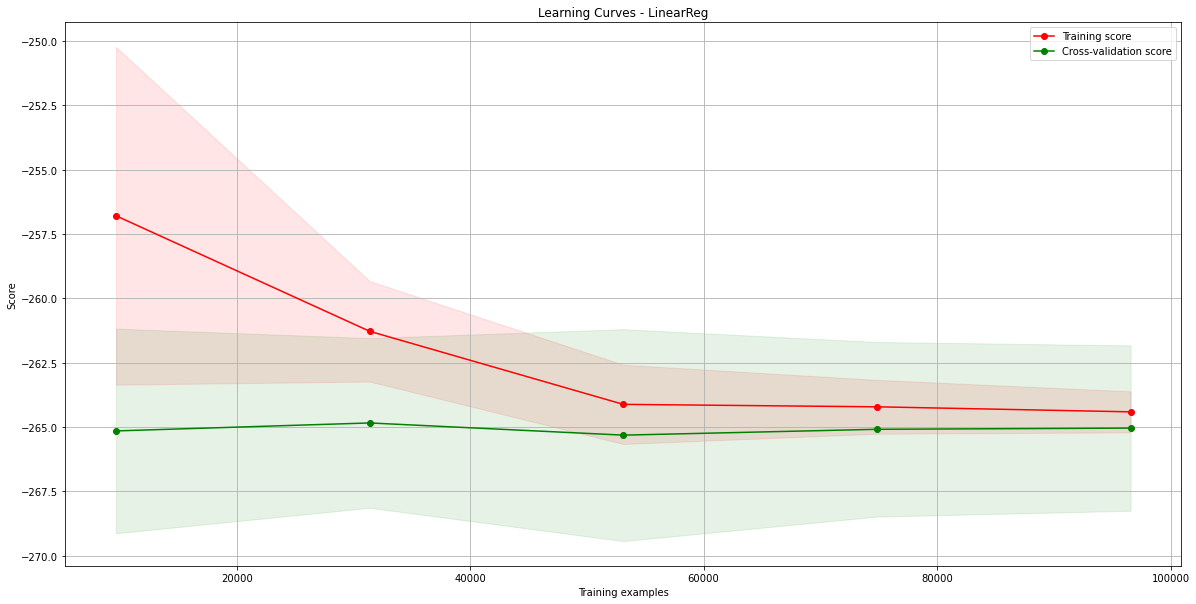

In [242]:
title = "Learning Curves - LinearReg"
plot_learning_curve(lr, title, x_train, y_train, cv=5, n_jobs=-1)

## ElasticNet

In [246]:
en = ElasticNet(random_state=0)
score = cross_val_score(en, X=x_train, y=y_train, cv=5, scoring='neg_root_mean_squared_error')
-score.mean()

265.0392799271112

In [249]:
en.fit(x_train, y_train)
pred_val = en.predict(x_test)
score = mean_squared_error(y_test,pred_val, squared=False)
score

262.12941191202344

<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

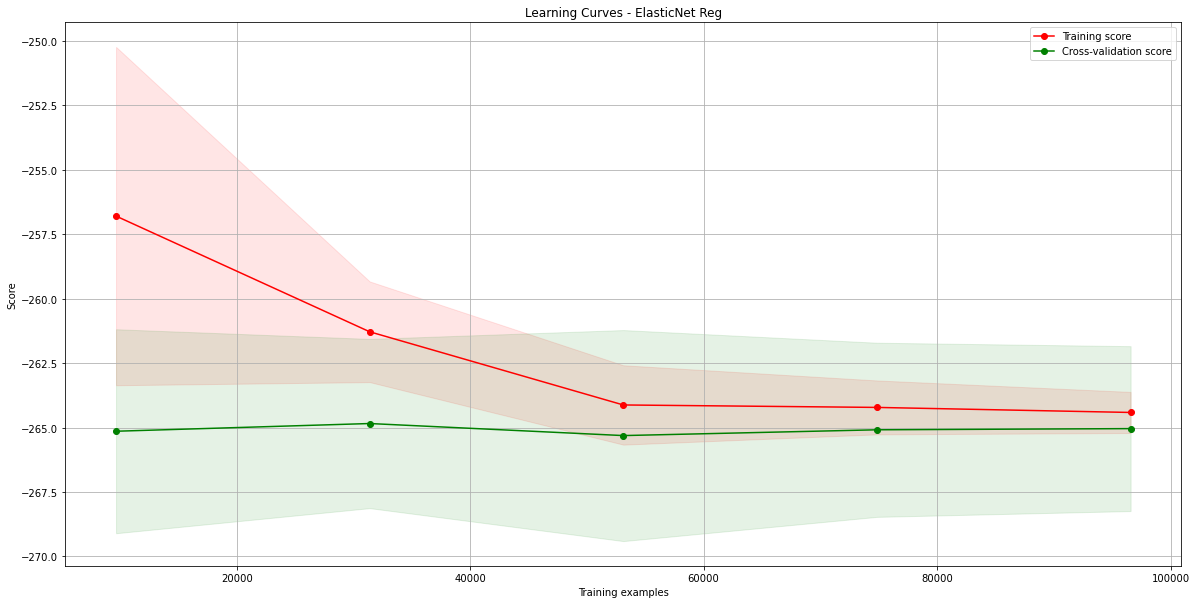

In [250]:
title = "Learning Curves - ElasticNet Reg"
plot_learning_curve(en, title, x_train, y_train, cv=5, n_jobs=-1)

# Submissão

In [324]:
en_pred = en.predict(df2_test)
en_pred_df = pd.DataFrame(en_pred, index=df2_test.index).reset_index()
en_pred_df.columns = ['ID_CLIENTE', 'VALOR']

In [348]:
sub4 = pd.DataFrame(df_sub['ID_CLIENTE']).set_index('ID_CLIENTE').join(en_pred_df.set_index('ID_CLIENTE'),
                                           on='ID_CLIENTE')

In [354]:
sub4.reset_index().isna().sum()

ID_CLIENTE       0
VALOR         8400
dtype: int64

In [355]:
sub4.reset_index().fillna(0).to_csv('C:/Users/ticom/VLabs/Submissions/sub4.csv', index=False)